In [21]:
import pandas as pd 
import polars as pl
import polars.selectors as cs
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
import plotnine as pn


In [2]:
df = (
    pl.read_parquet("data/data.parquet")
    # Add datestamp: should be either an integer indexing time or a timestamp
    .with_row_index(name="ds")
    # Fill nulls with 0
    .with_columns((cs.contains("Rate") | cs.contains("Size")).fill_null(0))
    # Basic features
    .with_columns(
        midprice=(pl.col("askRate0") * pl.col("bidRate0")) / 2,
        spread=pl.col("askRate0") - pl.col("bidRate0"),
        skew=pl.col("askSize0").log() - pl.col("bidSize0").log(),
        total_ask_size=pl.sum_horizontal(cs.contains("askSize")),
        total_bid_size=pl.sum_horizontal(cs.contains("bidSize")),
    )
    # Volume-Weighted Average Price (VWAP)
    .with_columns(
        ask_vmap=pl.col('total_ask_size') / pl.sum_horizontal(pl.col(f'askRate{i}') * pl.col(f'askSize{i}') for i in range(15)),
        bid_vmap=pl.col('total_bid_size') / pl.sum_horizontal(pl.col(f'bidRate{i}') * pl.col(f'bidSize{i}') for i in range(15)),
    )
)

In [3]:
data = df.select(["y", "ds"]).with_columns(unique_id=pl.lit("A")).head(10000).to_pandas()

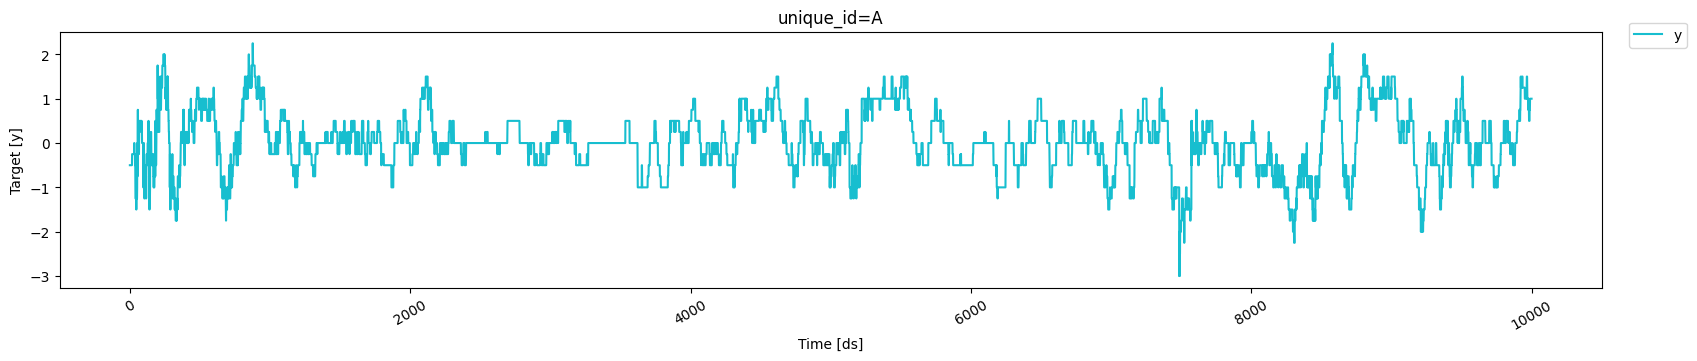

In [4]:
plot_series(data)

In [42]:
from statsforecast.models import AutoETS, AutoARIMA, AutoTBATS
from statsforecast import StatsForecast # required to instantiate StastForecast object and use cross-validation method

models = [
    AutoETS(season_length=1), 
    AutoARIMA(),
    AutoTBATS(season_length=1),
]

sf = StatsForecast(
    models=models, 
    freq=1, 
    n_jobs=12,
)

In [43]:
cross_sf = sf.cross_validation(
    df=data,
    h=100,
    # We also set step_size equal to the horizon. This parameter controls the distance
    # between each cross-validation window. By setting it equal to the horizon, we perform
    # chained cross-validation where the windows do not overlap.
    step_size=100,
    n_windows=2,
)

/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/statsforecast/tbats.py:571: RuntimeWarning: overflow encountered in square
/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/statsforecast/tbats.py:571: RuntimeWarning: overflow encountered in square
/home/pl487/time-series-prediction/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
/home/pl487/time-series-prediction/.venv/lib/pyt

In [44]:
pdata = (
    pl.from_pandas(cross_sf).join(pl.from_pandas(data), on="ds")
    .drop(["y_right", "unique_id"])
    .unpivot(index=["ds", "cutoff"])
)

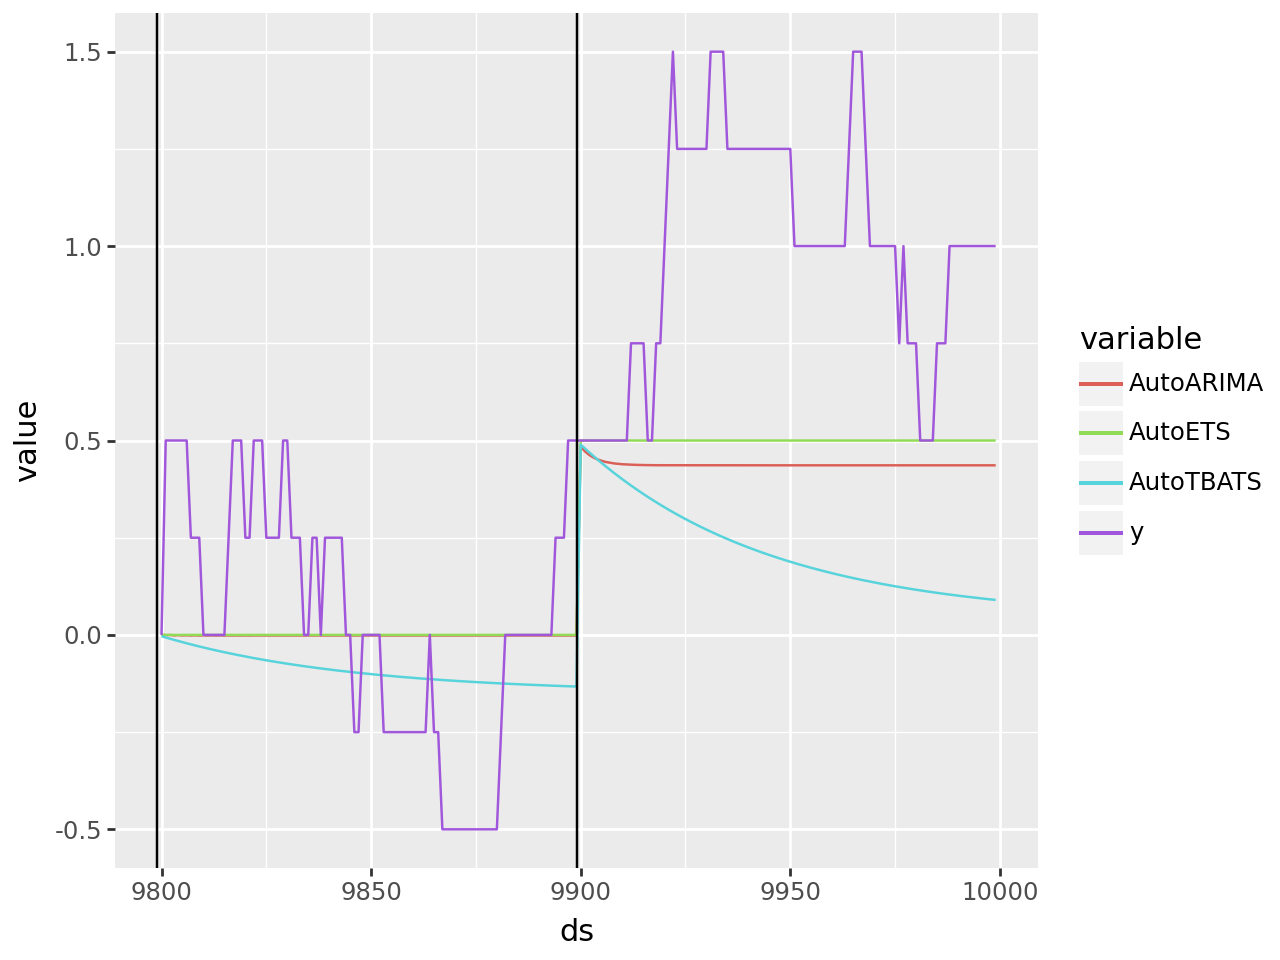

In [45]:
(
    pn.ggplot(pdata, pn.aes("ds", "value", colour="variable"))
    + pn.geom_line()
    + pn.geom_vline(pn.aes(xintercept="cutoff"))
)

In [48]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mse

from sklearn.metrics import r2_score

In [52]:
cv_rmse = evaluate(
    cross_sf.reset_index().drop(columns='cutoff'),
    metrics=[rmse, mse],
    agg_fn='mean',
)
cv_rmse

,metric,AutoETS,AutoARIMA,AutoTBATS
0,rmse,0.462030,0.496331,0.636664
1,mse,0.213472,0.246344,0.405341


In [ ]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression

fcst = MLForecast(
    models=LinearRegression(),
    freq=1,  # our serie has a monthly frequency
    lags=[100],
    target_transforms=[Differences([1])],
)
fcst.fit(data)


In [ ]:
preds = fcst.predict(200)
preds


In [ ]:
plot_series(data, preds)

In [ ]:
data

In [ ]:
cv_df = fcst.cross_validation(
    data,
    h=1_000,
    n_windows=10,
    step_size=100_000,
)

In [ ]:
data.join(preds, on=""

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse

res_rmse = evaluate(
    cv_df.drop(columns='cutoff'),
    metrics=[rmse],
    agg_fn='mean',
)
print(f"RMSE using cross-validation: {cv_rmse['LGBMRegressor'].item():.1f}")
